In [ ]:
# Setting up google drive
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
import sys
sys.path.append('/content/gdrive/MyDrive/Colab Notebooks')

In [1]:
# STEP 1: Create datasets, iterators

import torch
import torchvision
import torchvision.transforms as transforms

# Define transformations for data preprocessing
transform = transforms.Compose([
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),  # Normalization
     # transforms.Lambda(lambda x: x + torch.randn_like(x) * 0.1)  # Add Gaussian noise with std=0.1
])

batch_size = 64  # Define batch size for data loading

# Create the training set
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)  # Download CIFAR10 training set and apply transformations
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)  # Create a data loader for training set with shuffling

# Create the testing set
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)  # Download CIFAR10 testing set and apply transformations
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)  # Create a data loader for testing set without shuffling


100%|██████████| 170498071/170498071 [00:13<00:00, 12962525.49it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [2]:
# STEP 2: Define model architecture

import torch
import torch.nn as nn
import torch.nn.functional as F

class Block(nn.Module):
    def __init__(self, num_convs, input_channels, output_channels):
        super(Block, self).__init__()
        self.num_convs = num_convs  # Number of convolutional layers in the block
        self.input_channels = input_channels  # Number of input channels
        self.output_channels = output_channels  # Number of output channels for each convolutional layer

        # Define layers
        self.spatial_avg_pool = nn.AdaptiveAvgPool2d(1)  # Spatial average pooling layer to reduce spatial dimensions to 1x1
        self.linear = nn.Linear(input_channels, num_convs)  # Linear layer to calculate weights for each convolution
        self.activation = nn.ReLU()  # Activation function to introduce non-linearity

        self.conv_layers = nn.ModuleList([  # List of convolutional layers
            nn.Sequential(  # Each convolutional layer consists of the following operations
                nn.Conv2d(input_channels, output_channels, kernel_size=3, padding=1, stride=1),  # Convolutional operation
                nn.ReLU(inplace=True),  # ReLU activation function to introduce non-linearity
                nn.Dropout(p=0.4),  # Dropout layer to prevent overfitting by randomly dropping connections
                nn.BatchNorm2d(output_channels),  # Batch normalization to stabilize and speed up training
            )
            for _ in range(num_convs)  # Create num_convs number of convolutional layers
        ])

    def forward(self, x):
        # Spatial average pooling per channel to get a global representation
        spatial_avg = self.spatial_avg_pool(x).view(-1, self.input_channels)

        # Apply linear layer to calculate weights for each convolutional layer
        a = self.linear(spatial_avg)
        a = self.activation(a)  # Apply ReLU activation function
        # Reshape a for element-wise multiplication
        a = a.view(-1)

        # Combine convolutions with weights from a using element-wise multiplication and sum
        out = sum(a[i] * self.conv_layers[i](x) for i in range(self.num_convs))

        return out


class Backbone(nn.Module):
    def __init__(self, conv_arch):
        super(Backbone, self).__init__()
        in_channels = 3  # Number of input channels
        self.conv_arch = conv_arch  # Convolutional architecture configuration

        self.blocks = nn.ModuleList()  # List to hold multiple convolutional blocks
        for num_convs, out_channels in conv_arch:
            # Instantiate Block with specified number of convolutions and output channels
            block = Block(num_convs, in_channels, out_channels)
            # Add the block to the ModuleList
            self.blocks.append(block)
            # Update in_channels to equal out_channels for the next iteration
            in_channels = out_channels

        _, last_out_channels = conv_arch[-1]  # Extract the number of output channels from the last convolutional block
        self.classifier = nn.Sequential(
              nn.AdaptiveAvgPool2d(1),  # Adaptive average pooling layer to reduce spatial dimensions to 1x1
              nn.Conv2d(last_out_channels, last_out_channels, kernel_size=1, stride=1, padding=0, bias=False),  # 1x1 convolutional layer
              nn.ReLU(),
              nn.BatchNorm2d(last_out_channels),  # Batch normalization layer
              nn.AdaptiveAvgPool2d(1),  # Adaptive average pooling layer to reduce spatial dimensions to 1x1
              nn.ReLU(),  # ReLU activation function
              nn.AdaptiveAvgPool2d(1),  # Adaptive average pooling layer to reduce spatial dimensions to 1x1
              nn.Flatten(),  # Flatten the output tensor
              nn.Linear(last_out_channels, 10),  # Linear layer for classification with 10 output classes
        )

    def forward(self, x):
        for block in self.blocks:
            x = block(x)  # Pass input through each convolutional block

        x = self.classifier(x)  # Pass the output through the classifier

        return x  # Return the output tensor


In [3]:
# Auxilliary functions

def accuracy(y_hat, y):
    """Compute the number of correct predictions.

    Args:
        y_hat (tensor): Predicted values.
        y (tensor): Actual target values.

    Returns:
        float: Number of correct predictions.
    """
    # If y_hat is a matrix with scores for each class, get the index of the highest score
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
    # Compare predicted values with actual target values
    cmp = (y_hat.type(y.dtype) == y)  # because`==` is sensitive to data types
    # Return the number of correct predictions
    return float(torch.sum(cmp))

class Accumulator:
    """For accumulating sums over `n` variables."""
    def __init__(self, n):
        self.data = [0.0] * n  # Initialize list to hold accumulated values, all set to 0
    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]  # Add corresponding elements of args to self.data
    def reset(self):
        self.data = [0.0] * len(self.data)  # Reset all accumulated values to 0
    def __getitem__(self, idx):
        return self.data[idx]  # Get value at index idx

def evaluate_accuracy(net, data_iter):
    """Compute the accuracy for a model on a dataset.

    Args:
        net (torch.nn.Module): Model to evaluate.
        data_iter (torch.utils.data.DataLoader): Data loader for the dataset.

    Returns:
        float: Accuracy of the model on the dataset.
    """
    metric = Accumulator(2)  # Initialize accumulator to track correct predictions and total predictions
    for _, (X, y) in enumerate(data_iter):
        # Compute accuracy for each batch and add to accumulator
        metric.add(accuracy(net(X), y), len(y))  # Changed y.numel() to len(y)
    # Compute overall accuracy by dividing number of correct predictions by total predictions
    return metric[0] / metric[1]  # Accuracy = (number of correct predictions) / (total number of predictions)


import matplotlib.pyplot as plt
import torch
from IPython import display

class Animator:
    """For plotting data in animation."""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=(1, None),
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(8, 6)):
        """
        Initializes the Animator object.

        Args:
            xlabel (str, optional): Label for the x-axis. Defaults to None.
            ylabel (str, optional): Label for the y-axis. Defaults to None.
            legend (list, optional): List of legend labels. Defaults to None.
            xlim (tuple, optional): Tuple specifying the x-axis limits (min, max). Defaults to None.
            ylim (tuple, optional): Tuple specifying the y-axis limits (min, max). Defaults to None.
            xscale (str, optional): Scale of the x-axis ('linear' or 'log'). Defaults to 'linear'.
            yscale (str, optional): Scale of the y-axis ('linear' or 'log'). Defaults to 'linear'.
            fmts (tuple, optional): Tuple of line formats for plotting. Defaults to ('-', 'm--', 'g-.', 'r:').
            nrows (int, optional): Number of rows in the plot grid. Defaults to 1.
            ncols (int, optional): Number of columns in the plot grid. Defaults to 1.
            figsize (tuple, optional): Size of the figure (width, height) in inches. Defaults to (8, 6).
        """
        # Incrementally plot multiple lines
        if legend is None:
            legend = []
        self.fig, self.axes = plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # Use a lambda function to capture arguments
        self.config_axes = lambda: self.set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def set_axes(self, ax, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
        """
        Configures properties of the axes.

        Args:
            ax (matplotlib.axes.Axes): Axes object.
            xlabel (str): Label for the x-axis.
            ylabel (str): Label for the y-axis.
            xlim (tuple): Tuple specifying the x-axis limits (min, max).
            ylim (tuple): Tuple specifying the y-axis limits (min, max).
            xscale (str): Scale of the x-axis ('linear' or 'log').
            yscale (str): Scale of the y-axis ('linear' or 'log').
            legend (list): List of legend labels.
        """
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        ax.set_xscale(xscale)
        ax.set_yscale(yscale)
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
        ax.legend(legend)
        ax.grid()

    def add(self, x, y):
        """
        Adds data points to the plot.

        Args:
            x (list or tensor): List or tensor of x-coordinates.
            y (list or tensor): List or tensor of y-coordinates.
        """
        # Add multiple data points into the figure
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        # Check if the last value in x is a multiple of 10
        if x[-1] % 50 == 0 and x[-1] > 50:
            display.display(self.fig)


In [10]:
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt

def train(net, train_iter, test_iter, num_epochs, lr, gamma=0.1, step_size=20):
    """Train and evaluate a model with CPU or GPU."""

    def init_weights(m):
        """Initialize weights of linear and convolutional layers using Xavier uniform initialization."""
        if isinstance(m, (nn.Linear, nn.Conv2d)):
            torch.nn.init.xavier_uniform_(m.weight)

    net.apply(init_weights)  # Apply weight initialization function to the model

    # Choose device: CPU or GPU
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print('Training on', device)
    net.to(device)  # Move model to the chosen device

    # STEP 3: Define loss, optimizer
    loss = nn.CrossEntropyLoss()  # Cross-entropy loss function for classification tasks
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)  # Adam optimizer for training

    # Set up scheduler
    scheduler = StepLR(optimizer, step_size=step_size, gamma=gamma)

    # Initialize animator for plotting
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs],
                        legend=['train loss', 'train acc', 'test loss', 'test acc'])

    # Initialize lists for history
    train_acc_history, test_acc_history = [], []
    train_loss_history, test_loss_history = [], []

    # Initialize variables for early stopping
    threshold_acc = 0.8
    num_consecutive_epochs = 3
    consecutive_epochs_above_threshold = 0
    should_stop = False

    # Loop over epochs
    for epoch in range(num_epochs):
        # Initialize accumulators for training metrics
        metric = Accumulator(3)  # train_loss, train_acc, num_examples

        # Iterate over training data
        for i, (X, y) in enumerate(train_iter):
            net.train()  # Set model to training mode
            optimizer.zero_grad()  # Zero out gradients

            # Move data to the same device as the model
            X, y = X.to(device), y.to(device)
            y_hat = net(X)  # Forward pass
            l = loss(y_hat, y)  # Calculate loss
            l.backward()  # Backpropagation
            optimizer.step()  # Update model parameters

            with torch.no_grad():
                # Add batch metrics to the accumulator
                metric.add(l * X.size(0), accuracy(y_hat, y), X.size(0))

        scheduler.step()  # Update the scheduler

        # Switch to evaluation mode
        net.eval()

        # Initialize accumulators for test metrics
        test_metric = Accumulator(3)  # test_loss, test_acc, num_examples

        with torch.no_grad():
            # Iterate over test data
            for X_test, y_test in test_iter:
                # Move data to the same device as the model
                X_test, y_test = X_test.to(device), y_test.to(device)
                y_test_hat = net(X_test)  # Forward pass
                test_loss = loss(y_test_hat, y_test)  # Calculate loss
                # Add batch metrics to the test accumulator
                test_metric.add(test_loss * y_test.size(0), accuracy(y_test_hat, y_test), y_test.size(0))

        # Switch back to training mode
        net.train()

        # Calculate average train and test losses and accuracies
        train_loss, train_acc = metric[0] / metric[2], metric[1] / metric[2]
        test_loss, test_acc = test_metric[0] / test_metric[2], test_metric[1] / test_metric[2]

        # Add data points to the history for plotting
        train_acc_history.append(train_acc)
        test_acc_history.append(test_acc)
        train_loss_history.append(train_loss)
        test_loss_history.append(test_loss)

        # Add data points to the animator for plotting
        animator.add(epoch + 1, (train_loss, train_acc, test_loss, test_acc))

        # Print train and test metrics for the epoch
        train_acc_percentage = train_acc * 100
        test_acc_percentage = test_acc * 100
        print(f'Epoch [{epoch + 1}/{num_epochs}], '
              f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc_percentage:.2f}%, '
              f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc_percentage:.2f}%')

        # Check for early stopping condition
        if test_acc > threshold_acc:
            consecutive_epochs_above_threshold += 1
            if consecutive_epochs_above_threshold >= num_consecutive_epochs:
                print(f"Early stopping at epoch {epoch + 1} as test accuracy has been above {threshold_acc} for {num_consecutive_epochs} consecutive epochs.")
                should_stop = True
                break
        else:
            consecutive_epochs_above_threshold = 0

    # Final accuracies
    final_train_acc_percentage = train_acc * 100
    final_test_acc_percentage = test_acc * 100
    print(f'Final loss: {train_loss:.4f}, Final train acc: {final_train_acc_percentage:.2f}%, '
          f'Final test loss: {test_loss:.4f}, Final test acc: {final_test_acc_percentage:.2f}%')

    # Plot training history after training is complete
    plot_training_history(train_acc_history, test_acc_history, train_loss_history, test_loss_history)

    return should_stop


In [15]:
import matplotlib.pyplot as plt

def plot_training_history(train_acc_history, test_acc_history, train_loss_history, test_loss_history):
    plt.figure(figsize=(10, 5))

    # Plotting accuracy
    plt.subplot(1, 2, 1)
    plt.plot(range(1, len(train_acc_history) + 1), train_acc_history, label='Train Acc')
    plt.plot(range(1, len(test_acc_history) + 1), test_acc_history, label='Test Acc')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and Testing Accuracy')

    # Plotting loss
    plt.subplot(1, 2, 2)
    plt.plot(range(1, len(train_loss_history) + 1), train_loss_history, label='Train Loss')
    plt.plot(range(1, len(test_loss_history) + 1), test_loss_history, label='Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Testing Loss')

    plt.tight_layout()
    plt.show()


In [16]:
def plot_predictions(model, testloader, classes, num_images=10):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    model.eval()  # Set the model to evaluation mode
    images, labels = next(iter(testloader))  # Get a batch of test images and labels
    images, labels = images.to(device), labels.to(device)  # Move them to the same device as the model

    with torch.no_grad():  # Disable gradient calculation
        outputs = model(images)  # Forward pass to get outputs
        _, predicted = torch.max(outputs, 1)  # Get predicted labels

    # Plot the first `num_images` images and their predictions
    plt.figure(figsize=(15, 6))
    for i in range(num_images):
        ax = plt.subplot(2, 5, i + 1)
        plt.imshow(images[i].cpu().numpy().transpose(1, 2, 0))  # Move image back to CPU for plotting
        plt.title(f"Predicted: {classes[predicted[i]]}, Actual: {classes[labels[i]]}")
        plt.axis('off')
    plt.show()


Training on cuda
Epoch [1/40], Train Loss: 1.9256, Train Acc: 28.20%, Test Loss: 236.5811, Test Acc: 15.69%
Epoch [2/40], Train Loss: 1.5871, Train Acc: 41.04%, Test Loss: 113.8670, Test Acc: 17.12%
Epoch [3/40], Train Loss: 1.3960, Train Acc: 49.22%, Test Loss: 126.5890, Test Acc: 36.66%
Epoch [4/40], Train Loss: 1.2296, Train Acc: 55.32%, Test Loss: 3.4348, Test Acc: 41.28%
Epoch [5/40], Train Loss: 1.0914, Train Acc: 60.89%, Test Loss: 2.3399, Test Acc: 53.49%
Epoch [6/40], Train Loss: 0.9781, Train Acc: 65.34%, Test Loss: 2.0933, Test Acc: 59.07%
Epoch [7/40], Train Loss: 0.8973, Train Acc: 68.10%, Test Loss: 1.4278, Test Acc: 58.67%
Epoch [8/40], Train Loss: 0.8303, Train Acc: 70.58%, Test Loss: 1.2109, Test Acc: 64.63%
Epoch [9/40], Train Loss: 0.7726, Train Acc: 72.89%, Test Loss: 1.0981, Test Acc: 66.65%
Epoch [10/40], Train Loss: 0.7269, Train Acc: 74.36%, Test Loss: 1.1689, Test Acc: 70.10%
Epoch [11/40], Train Loss: 0.6871, Train Acc: 75.78%, Test Loss: 1.0403, Test Acc: 70.

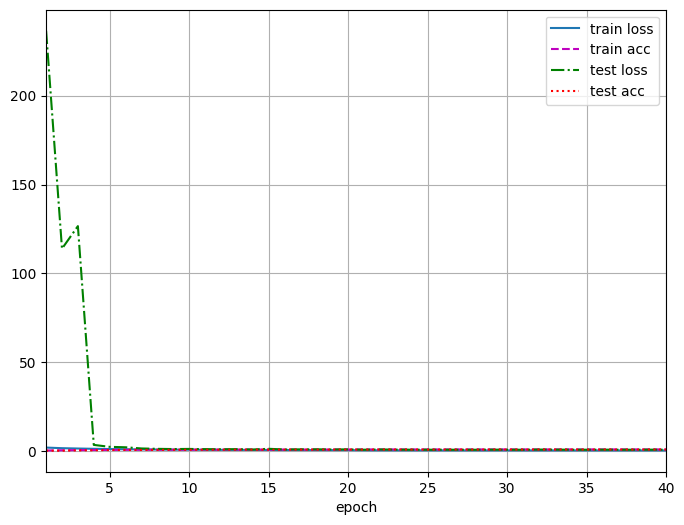

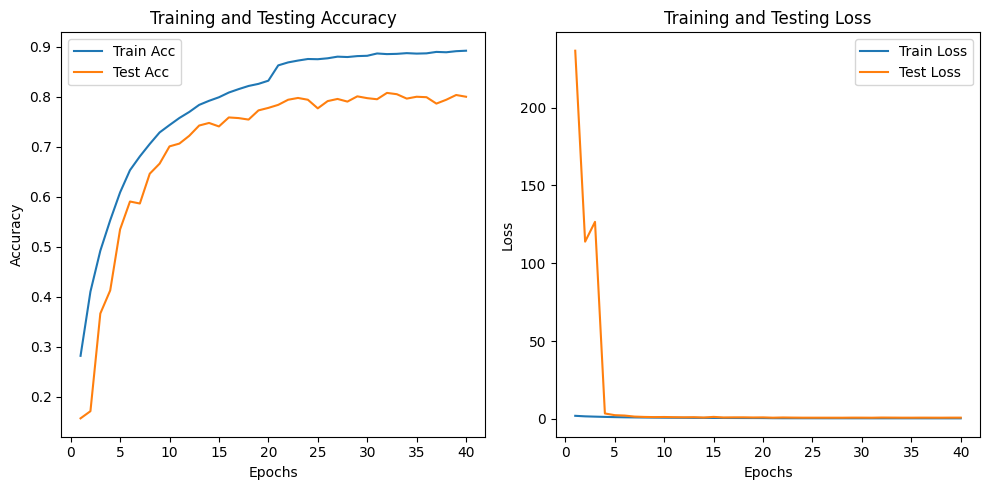

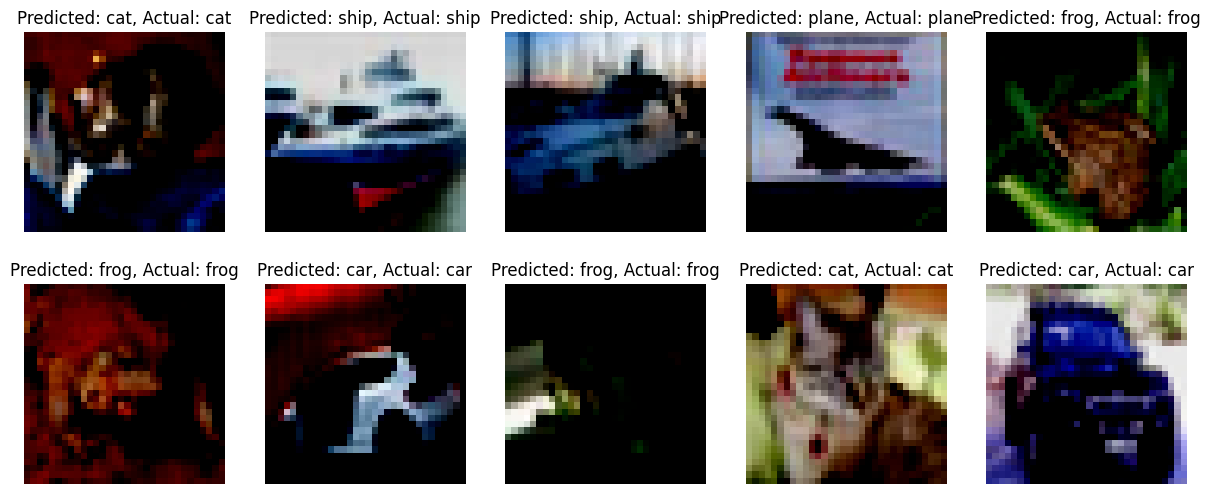

In [19]:
if __name__ == "__main__":
    conv_arch = [(5, 32), (5, 64), (5, 64), (5, 128)]

    model = Backbone(conv_arch)
    num_epochs = 40
    lr = 0.001

    train(model, trainloader, testloader, num_epochs, lr)

    # Define your classes (this assumes you have a list of class names)
    classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

    # Call prediction visualization function
    plot_predictions(model, testloader, classes)